# ============================================================================
# CUADERNILLO: Evaluación Avanzada y Análisis Detallado
# ============================================================================

# # Evaluación Avanzada del Modelo LSTM
# Este cuadernillo implementa técnicas avanzadas de evaluación incluyendo:
- Validación Cruzada Temporal
- Curvas ROC multiclase
- Análisis de errores detallado
- Métricas de transición temporal

In [1]:
# %% Celda 1: Importar librerías
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (roc_curve, auc, roc_auc_score, 
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [2]:
# %% Celda 2: Cargar modelo y datos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

# Cargar modelo y datos guardados
checkpoint = torch.load('../models/lstm_model_final.pth', weights_only=False)
le = checkpoint['label_encoder']
print(f"Label Encoder cargado con {len(le.classes_)} clases")

# Cargar datos procesados
data = pd.read_csv('../data/processed/physical_exercise_enriched.csv')
print(f"Datos cargados: {data.shape}")

Dispositivo: cuda
Label Encoder cargado con 6 clases
Datos cargados: (45454, 48)


In [3]:
# %% Celda 3: Preparar datos para evaluación
from torch.utils.data import Dataset, DataLoader

def create_sequences(data, seq_length=10):
    sequences = []
    targets = []
    
    feature_cols = ['x_nose', 'y_nose', 'x_left_shoulder', 'y_left_shoulder', 
                   'x_right_shoulder', 'y_right_shoulder', 'x_left_elbow', 'y_left_elbow',
                   'x_right_elbow', 'y_right_elbow', 'x_left_wrist', 'y_left_wrist',
                   'x_right_wrist', 'y_right_wrist', 'x_left_hip', 'y_left_hip',
                   'x_right_hip', 'y_right_hip', 'x_left_knee', 'y_left_knee',
                   'x_right_knee', 'y_right_knee', 'x_left_ankle', 'y_left_ankle',
                   'x_right_ankle', 'y_right_ankle', 'right_elbow_angle',
                   'left_elbow_angle', 'right_knee_angle', 'left_knee_angle']
    
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][feature_cols].values
        target = data.iloc[i + seq_length]['pose']
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

sequences, targets = create_sequences(data, seq_length=10)
targets_encoded = le.transform(targets)
print(f"Secuencias creadas: {sequences.shape}")

class ExerciseDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.LongTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


Secuencias creadas: (45444, 10, 30)


In [4]:
# %% Celda 4: Validación Cruzada Temporal
print("\n" + "="*70)
print("VALIDACIÓN CRUZADA TEMPORAL (Time Series Split)")
print("="*70)

# Definir modelo
class LSTMModel(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_layers=2, 
                 num_classes=6, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

def train_and_evaluate_fold(X_train, y_train, X_val, y_val, fold_num):
    """Entrena y evalúa un fold"""
    # Crear datasets
    train_dataset = ExerciseDataset(X_train, y_train)
    val_dataset = ExerciseDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Crear modelo
    model = LSTMModel(input_size=30, hidden_size=64, num_layers=2, 
                     num_classes=len(le.classes_), dropout=0.3).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Entrenar por pocas épocas (para validación cruzada rápida)
    num_epochs = 20
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # Entrenar
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validar
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_acc = 100 * correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
    
    final_acc = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'accuracy': final_acc * 100,
        'balanced_accuracy': balanced_acc * 100,
        'f1_score': f1,
        'predictions': all_preds,
        'labels': all_labels
    }

# Realizar validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

print("\nRealizando validación cruzada temporal (5 folds)...")
print("Nota: Cada fold puede tardar varios minutos\n")

for fold, (train_idx, val_idx) in enumerate(tscv.split(sequences)):
    print(f"Fold {fold + 1}/5:")
    print(f"  Train: {len(train_idx)} muestras, Val: {len(val_idx)} muestras")
    
    X_train_fold = sequences[train_idx]
    y_train_fold = targets_encoded[train_idx]
    X_val_fold = sequences[val_idx]
    y_val_fold = targets_encoded[val_idx]
    
    result = train_and_evaluate_fold(X_train_fold, y_train_fold, 
                                     X_val_fold, y_val_fold, fold + 1)
    
    cv_results.append(result)
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Balanced Accuracy: {result['balanced_accuracy']:.2f}%")
    print(f"  F1-Score: {result['f1_score']:.4f}\n")

# Resumen de validación cruzada
print("="*70)
print("RESUMEN DE VALIDACIÓN CRUZADA")
print("="*70)
accuracies = [r['accuracy'] for r in cv_results]
balanced_accs = [r['balanced_accuracy'] for r in cv_results]
f1_scores = [r['f1_score'] for r in cv_results]

print(f"Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
print(f"Balanced Accuracy: {np.mean(balanced_accs):.2f}% ± {np.std(balanced_accs):.2f}%")
print(f"F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


VALIDACIÓN CRUZADA TEMPORAL (Time Series Split)

Realizando validación cruzada temporal (5 folds)...
Nota: Cada fold puede tardar varios minutos

Fold 1/5:
  Train: 7574 muestras, Val: 7574 muestras
  Accuracy: 71.24%
  Balanced Accuracy: 71.28%
  F1-Score: 0.7326

Fold 2/5:
  Train: 15148 muestras, Val: 7574 muestras
  Accuracy: 46.57%
  Balanced Accuracy: 39.66%
  F1-Score: 0.4196

Fold 3/5:
  Train: 22722 muestras, Val: 7574 muestras
  Accuracy: 71.44%
  Balanced Accuracy: 49.14%
  F1-Score: 0.7684

Fold 4/5:
  Train: 30296 muestras, Val: 7574 muestras
  Accuracy: 16.78%
  Balanced Accuracy: 33.20%
  F1-Score: 0.1263

Fold 5/5:
  Train: 37870 muestras, Val: 7574 muestras
  Accuracy: 59.55%
  Balanced Accuracy: 59.05%
  F1-Score: 0.7236

RESUMEN DE VALIDACIÓN CRUZADA
Accuracy: 53.12% ± 20.34%
Balanced Accuracy: 50.47% ± 13.59%
F1-Score: 0.5541 ± 0.2480


In [5]:
# %% Celda 5: Cargar modelo final para análisis ROC
print("\n=== CARGANDO MODELO FINAL PARA ANÁLISIS ===")
model = LSTMModel(input_size=30, hidden_size=64, num_layers=2, 
                 num_classes=len(le.classes_), dropout=0.3).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Obtener predicciones con probabilidades
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    sequences, targets_encoded, test_size=0.2, random_state=42, stratify=targets_encoded
)

test_dataset = ExerciseDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

print(f"Probabilidades obtenidas: {all_probs.shape}")


=== CARGANDO MODELO FINAL PARA ANÁLISIS ===
Probabilidades obtenidas: (9089, 6)



=== GENERANDO CURVAS ROC ===


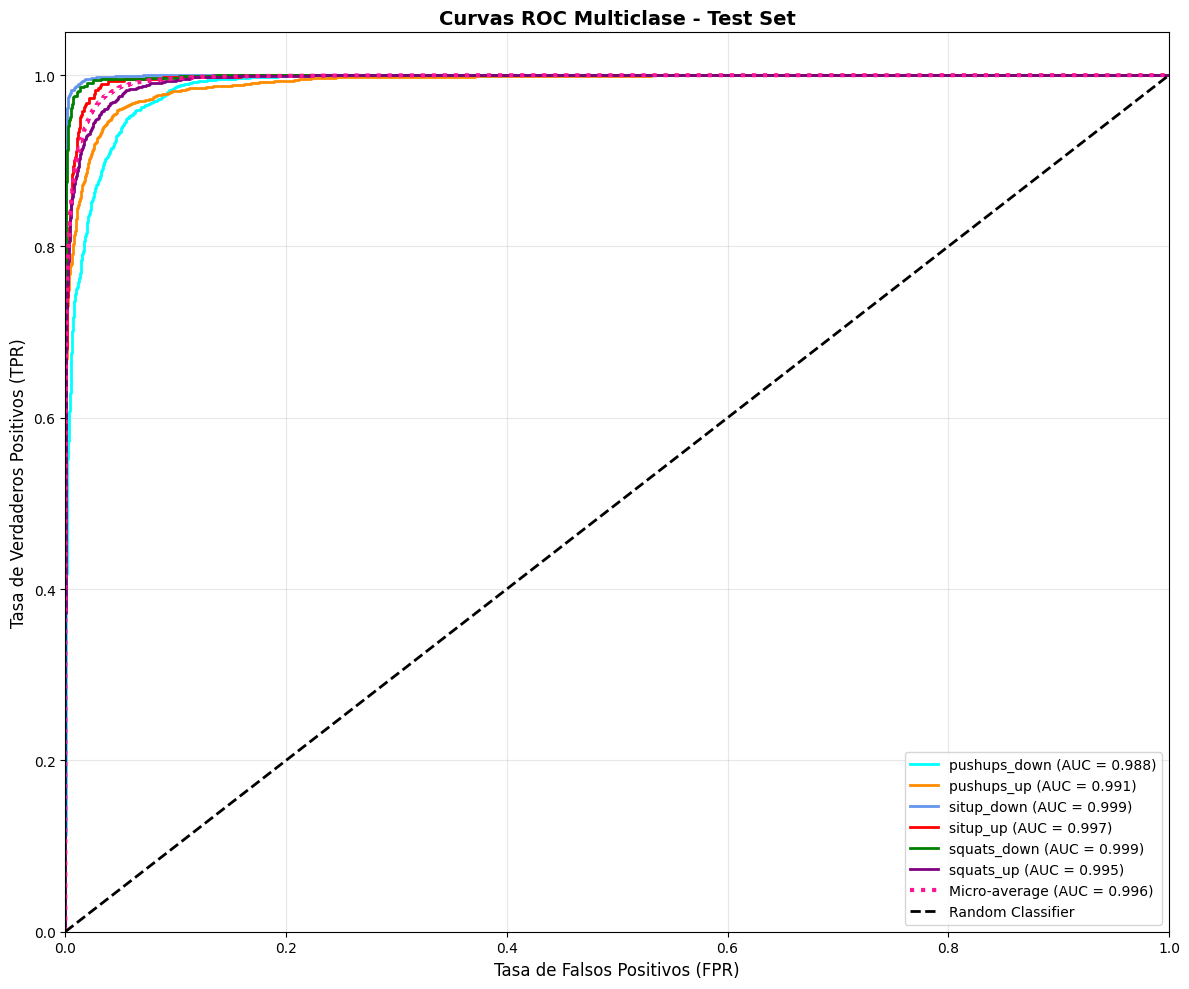


AUC por clase:
  pushups_down   : 0.9883
  pushups_up     : 0.9911
  situp_down     : 0.9994
  situp_up       : 0.9968
  squats_down    : 0.9988
  squats_up      : 0.9950
  Micro-average  : 0.9959


In [6]:
# %% Celda 6: Curvas ROC Multiclase
print("\n=== GENERANDO CURVAS ROC ===")

# Binarizar las etiquetas
y_test_bin = label_binarize(all_labels, classes=range(len(le.classes_)))
n_classes = len(le.classes_)

# Calcular ROC curve y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular micro-average ROC curve y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average
ax.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=3,
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')

# Línea diagonal
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
ax.set_title('Curvas ROC Multiclase - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/roc_curves_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAUC por clase:")
for i in range(n_classes):
    print(f"  {le.classes_[i]:<15}: {roc_auc[i]:.4f}")
print(f"  {'Micro-average':<15}: {roc_auc['micro']:.4f}")


=== GENERANDO CURVAS PRECISION-RECALL ===


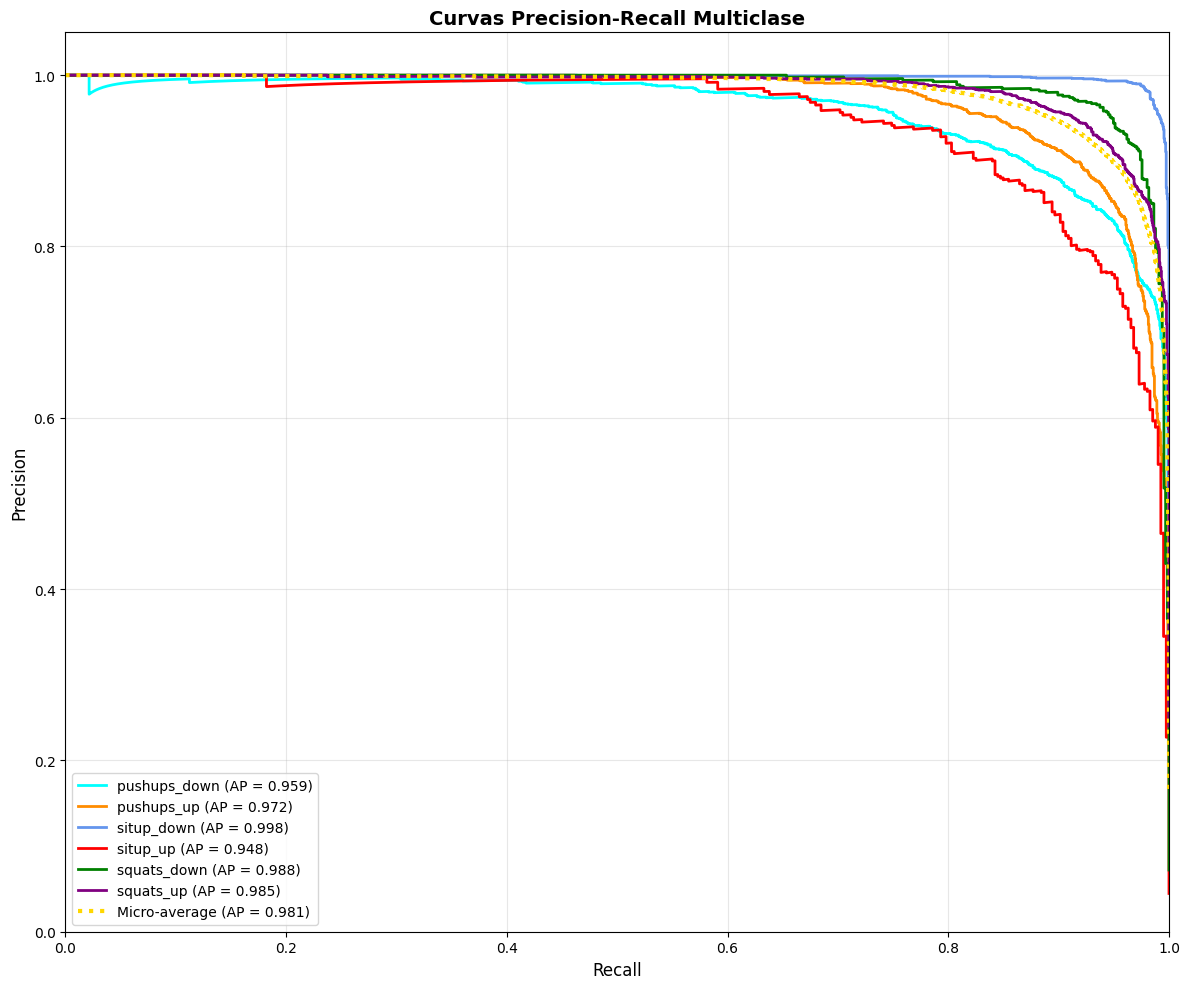


Average Precision por clase:
  pushups_down   : 0.9592
  pushups_up     : 0.9718
  situp_down     : 0.9978
  situp_up       : 0.9480
  squats_down    : 0.9882
  squats_up      : 0.9848
  Micro-average  : 0.9815


In [7]:
# %% Celda 7: Curvas Precision-Recall
print("\n=== GENERANDO CURVAS PRECISION-RECALL ===")

precision_dict = dict()
recall_dict = dict()
avg_precision = dict()

for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(
        y_test_bin[:, i], all_probs[:, i]
    )
    avg_precision[i] = average_precision_score(y_test_bin[:, i], all_probs[:, i])

# Micro-average
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), all_probs.ravel()
)
avg_precision["micro"] = average_precision_score(y_test_bin, all_probs, average="micro")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    ax.plot(recall_dict[i], precision_dict[i], color=color, lw=2,
            label=f'{le.classes_[i]} (AP = {avg_precision[i]:.3f})')

# Plot micro-average
ax.plot(recall_dict["micro"], precision_dict["micro"], color='gold', 
        linestyle=':', lw=3,
        label=f'Micro-average (AP = {avg_precision["micro"]:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Curvas Precision-Recall Multiclase', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAverage Precision por clase:")
for i in range(n_classes):
    print(f"  {le.classes_[i]:<15}: {avg_precision[i]:.4f}")
print(f"  {'Micro-average':<15}: {avg_precision['micro']:.4f}")



=== ANÁLISIS DE CONFIANZA DE PREDICCIONES ===

Estadísticas de confianza:
  Media: 0.9358
  Mediana: 0.9963
  Desviación estándar: 0.1219
  Mínima: 0.3361
  Máxima: 1.0000

Confianza promedio por clase:
  pushups_down   : 0.8902
  pushups_up     : 0.9316
  situp_down     : 0.9855
  situp_up       : 0.9154
  squats_down    : 0.9635
  squats_up      : 0.9321

Comparación correctas vs incorrectas:
  Confianza (correctas): 0.9533 ± 0.0998
  Confianza (incorrectas): 0.7195 ± 0.1573


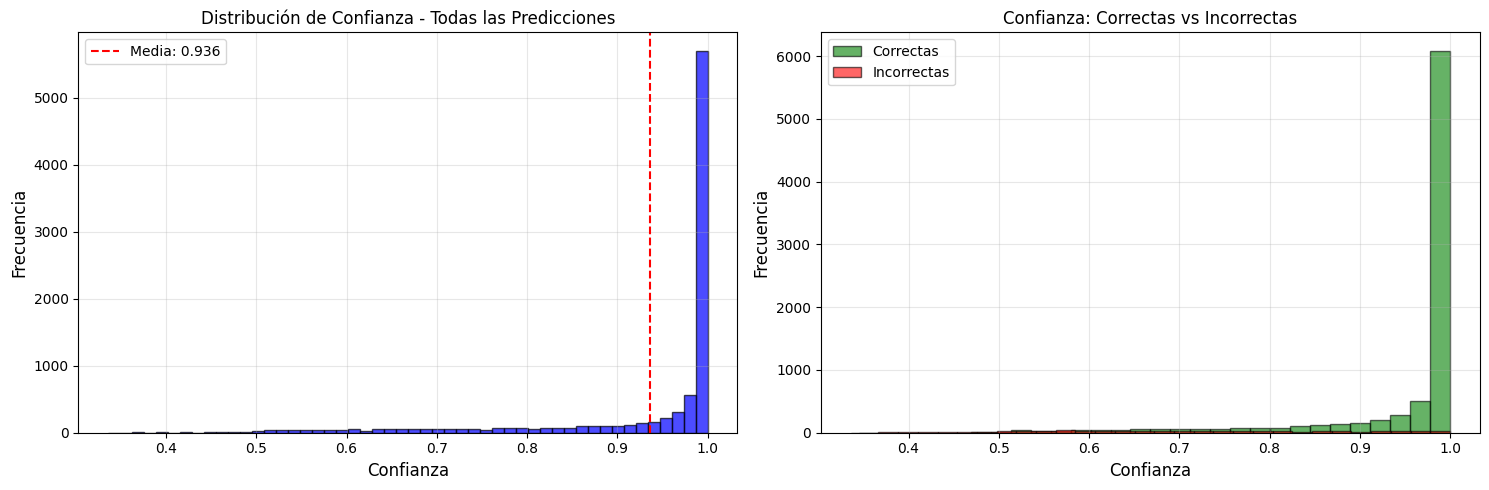

In [8]:
# %% Celda 8: Análisis de Confianza
print("\n=== ANÁLISIS DE CONFIANZA DE PREDICCIONES ===")

predictions = np.argmax(all_probs, axis=1)
confidences = np.max(all_probs, axis=1)

# Estadísticas de confianza
print(f"\nEstadísticas de confianza:")
print(f"  Media: {np.mean(confidences):.4f}")
print(f"  Mediana: {np.median(confidences):.4f}")
print(f"  Desviación estándar: {np.std(confidences):.4f}")
print(f"  Mínima: {np.min(confidences):.4f}")
print(f"  Máxima: {np.max(confidences):.4f}")

# Confianza por clase
print(f"\nConfianza promedio por clase:")
for i in range(n_classes):
    mask = predictions == i
    if mask.sum() > 0:
        avg_conf = confidences[mask].mean()
        print(f"  {le.classes_[i]:<15}: {avg_conf:.4f}")

# Comparar confianza entre predicciones correctas e incorrectas
correct_mask = predictions == all_labels
correct_confidences = confidences[correct_mask]
incorrect_confidences = confidences[~correct_mask]

print(f"\nComparación correctas vs incorrectas:")
print(f"  Confianza (correctas): {correct_confidences.mean():.4f} ± {correct_confidences.std():.4f}")
if len(incorrect_confidences) > 0:
    print(f"  Confianza (incorrectas): {incorrect_confidences.mean():.4f} ± {incorrect_confidences.std():.4f}")

# Visualizar distribución de confianza
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma general
axes[0].hist(confidences, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(np.mean(confidences), color='red', linestyle='--', 
               label=f'Media: {np.mean(confidences):.3f}')
axes[0].set_xlabel('Confianza', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Confianza - Todas las Predicciones', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Comparación correctas vs incorrectas
axes[1].hist(correct_confidences, bins=30, alpha=0.6, color='green', 
            label='Correctas', edgecolor='black')
if len(incorrect_confidences) > 0:
    axes[1].hist(incorrect_confidences, bins=30, alpha=0.6, color='red', 
                label='Incorrectas', edgecolor='black')
axes[1].set_xlabel('Confianza', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Confianza: Correctas vs Incorrectas', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# %% Celda 9: Análisis de Transiciones Temporales
print("\n=== ANÁLISIS DE TRANSICIONES TEMPORALES ===")

def analyze_transitions(y_true, y_pred, class_names):
    """Analiza las transiciones entre estados"""
    # Detectar transiciones
    true_transitions = []
    pred_transitions = []
    
    for i in range(len(y_true) - 1):
        if y_true[i] != y_true[i+1]:
            true_transitions.append((i, class_names[y_true[i]], class_names[y_true[i+1]]))
        if y_pred[i] != y_pred[i+1]:
            pred_transitions.append((i, class_names[y_pred[i]], class_names[y_pred[i+1]]))
    
    print(f"Transiciones reales: {len(true_transitions)}")
    print(f"Transiciones predichas: {len(pred_transitions)}")
    
    # Calcular accuracy de transiciones (con tolerancia de ±2 frames)
    tolerance = 2
    correct_transitions = 0
    
    for true_idx, true_from, true_to in true_transitions:
        for pred_idx, pred_from, pred_to in pred_transitions:
            if abs(true_idx - pred_idx) <= tolerance:
                if true_from == pred_from and true_to == pred_to:
                    correct_transitions += 1
                    break
    
    transition_acc = correct_transitions / len(true_transitions) if len(true_transitions) > 0 else 0
    print(f"Accuracy de transiciones (±{tolerance} frames): {transition_acc*100:.2f}%")
    
    # Tipos de transiciones más comunes
    from collections import Counter
    true_trans_types = [(t[1], t[2]) for t in true_transitions]
    pred_trans_types = [(t[1], t[2]) for t in pred_transitions]
    
    print("\nTransiciones reales más comunes:")
    for (from_class, to_class), count in Counter(true_trans_types).most_common(5):
        print(f"  {from_class} → {to_class}: {count} veces")
    
    return true_transitions, pred_transitions, transition_acc

true_trans, pred_trans, trans_acc = analyze_transitions(
    all_labels, predictions, le.classes_
)


=== ANÁLISIS DE TRANSICIONES TEMPORALES ===
Transiciones reales: 7258
Transiciones predichas: 7246
Accuracy de transiciones (±2 frames): 87.21%

Transiciones reales más comunes:
  situp_down → squats_up: 509 veces
  squats_up → pushups_down: 508 veces
  pushups_down → squats_up: 506 veces
  squats_up → situp_down: 485 veces
  squats_up → pushups_up: 467 veces


In [10]:
# %% Celda 10: Análisis de Suavidad (Smoothness)
print("\n=== ANÁLISIS DE SUAVIDAD ===")

def calculate_smoothness_metrics(predictions):
    """Calcula métricas de suavidad"""
    changes = np.sum(predictions[1:] != predictions[:-1])
    smoothness = 1 - (changes / (len(predictions) - 1))
    
    # Duración promedio de cada predicción
    from itertools import groupby
    durations = [len(list(group)) for _, group in groupby(predictions)]
    
    return {
        'smoothness': smoothness,
        'total_changes': changes,
        'avg_duration': np.mean(durations),
        'median_duration': np.median(durations),
        'min_duration': np.min(durations),
        'max_duration': np.max(durations)
    }

smoothness_metrics = calculate_smoothness_metrics(predictions)

print(f"Suavidad: {smoothness_metrics['smoothness']*100:.2f}%")
print(f"Total de cambios: {smoothness_metrics['total_changes']}")
print(f"Duración promedio por predicción: {smoothness_metrics['avg_duration']:.2f} frames")
print(f"Duración mediana: {smoothness_metrics['median_duration']:.1f} frames")
print(f"Duración mínima/máxima: {smoothness_metrics['min_duration']}/{smoothness_metrics['max_duration']} frames")




=== ANÁLISIS DE SUAVIDAD ===
Suavidad: 20.27%
Total de cambios: 7246
Duración promedio por predicción: 1.25 frames
Duración mediana: 1.0 frames
Duración mínima/máxima: 1/7 frames



=== ANÁLISIS DE CALIBRACIÓN ===


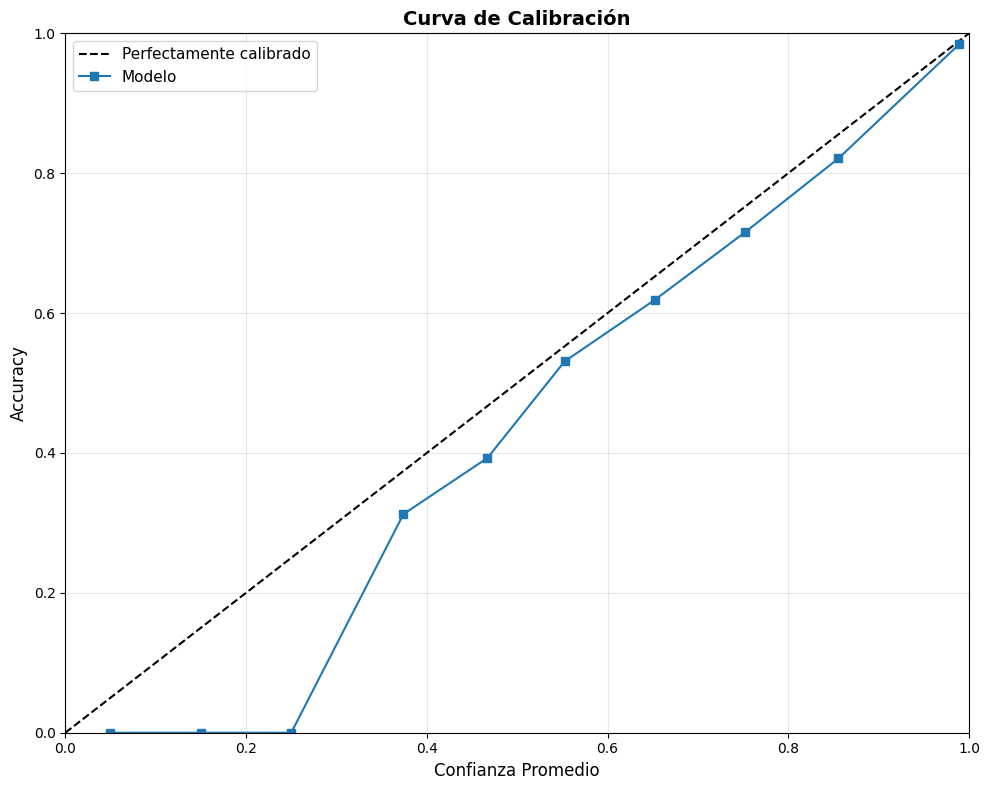

Expected Calibration Error (ECE): 0.0717


In [11]:
# %% Celda 11: Matriz de Calibración
print("\n=== ANÁLISIS DE CALIBRACIÓN ===")

def plot_calibration_curve(y_true, y_probs, n_bins=10):
    """Grafica curva de calibración"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Obtener confianzas y predicciones
    confidences = np.max(y_probs, axis=1)
    predictions = np.argmax(y_probs, axis=1)
    accuracies_per_bin = []
    confidences_per_bin = []
    
    # Dividir en bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        
        # Máscara para este bin
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        
        if in_bin.sum() > 0:
            bin_acc = (predictions[in_bin] == y_true[in_bin]).mean()
            bin_conf = confidences[in_bin].mean()
            accuracies_per_bin.append(bin_acc)
            confidences_per_bin.append(bin_conf)
        else:
            accuracies_per_bin.append(0)
            confidences_per_bin.append((bin_lower + bin_upper) / 2)
    
    # Plot
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')
    ax.plot(confidences_per_bin, accuracies_per_bin, 's-', label='Modelo')
    
    ax.set_xlabel('Confianza Promedio', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Curva de Calibración', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('../reports/calibration_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Expected Calibration Error (ECE)
    ece = np.mean(np.abs(np.array(accuracies_per_bin) - np.array(confidences_per_bin)))
    print(f"Expected Calibration Error (ECE): {ece:.4f}")
    
    return ece

ece = plot_calibration_curve(all_labels, all_probs, n_bins=10)

In [12]:
# %% Celda 12: Resumen Final
print("\n" + "="*70)
print("RESUMEN COMPLETO DE EVALUACIÓN AVANZADA")
print("="*70)

print("\n1. VALIDACIÓN CRUZADA TEMPORAL:")
print(f"   - Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
print(f"   - F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print("\n2. CURVAS ROC:")
print(f"   - AUC Micro-average: {roc_auc['micro']:.4f}")
for i in range(n_classes):
    print(f"   - {le.classes_[i]}: {roc_auc[i]:.4f}")

print("\n3. CONFIANZA:")
print(f"   - Confianza media: {np.mean(confidences):.4f}")
print(f"   - Correctas: {correct_confidences.mean():.4f}")
if len(incorrect_confidences) > 0:
    print(f"   - Incorrectas: {incorrect_confidences.mean():.4f}")

print("\n4. TRANSICIONES TEMPORALES:")
print(f"   - Accuracy de transiciones: {trans_acc*100:.2f}%")
print(f"   - Suavidad: {smoothness_metrics['smoothness']*100:.2f}%")

print("\n5. CALIBRACIÓN:")
print(f"   - Expected Calibration Error: {ece:.4f}")

print("\n" + "="*70)
print("✅ EVALUACIÓN AVANZADA COMPLETADA")
print("="*70)
print("\nArchivos generados:")
print("  - ../reports/roc_curves_multiclass.png")
print("  - ../reports/precision_recall_curves.png")
print("  - ../reports/confidence_analysis.png")
print("  - ../reports/calibration_curve.png")


RESUMEN COMPLETO DE EVALUACIÓN AVANZADA

1. VALIDACIÓN CRUZADA TEMPORAL:
   - Accuracy: 53.12% ± 20.34%
   - F1-Score: 0.5541 ± 0.2480

2. CURVAS ROC:
   - AUC Micro-average: 0.9959
   - pushups_down: 0.9883
   - pushups_up: 0.9911
   - situp_down: 0.9994
   - situp_up: 0.9968
   - squats_down: 0.9988
   - squats_up: 0.9950

3. CONFIANZA:
   - Confianza media: 0.9358
   - Correctas: 0.9533
   - Incorrectas: 0.7195

4. TRANSICIONES TEMPORALES:
   - Accuracy de transiciones: 87.21%
   - Suavidad: 20.27%

5. CALIBRACIÓN:
   - Expected Calibration Error: 0.0717

✅ EVALUACIÓN AVANZADA COMPLETADA

Archivos generados:
  - ../reports/roc_curves_multiclass.png
  - ../reports/precision_recall_curves.png
  - ../reports/confidence_analysis.png
  - ../reports/calibration_curve.png
